In [1]:
import sys
sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
from VQE_v2 import VQE
from GroupingAlgorithm import *
from utils import get_backend_conectivity, RandomHamiltonian
# Importing standard Qiskit libraries
from qiskit import IBMQ, QuantumCircuit
from qiskit import Aer
from qiskit.circuit.library import EfficientSU2
from qiskit.utils.quantum_instance import QuantumInstance
from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter
from qiskit.algorithms.optimizers import SPSA
from IPython.display import display, clear_output

In this notebook we test the VQE class. First we load our IBM account and define the backends. 

In [2]:
IBMQ.load_account()
provider      = IBMQ.get_provider(hub='ibm-q-csic', group='internal', project='iff-csic') 
backend_paris = provider.get_backend('ibmq_montreal')
WC_paris      = get_backend_conectivity(backend_paris)
backend_sim   = Aer.get_backend('aer_simulator') # Backend for simulation
NUM_SHOTS = 2**13  # Number of shots for each circuit

We create a Hamiltonian to perform the test.

In [3]:
# qubit_op, init_state = LiH(initial_state=True)
# num_qubits = qubit_op.num_qubits

In [4]:
num_qubits = 2
qubit_op = RandomHamiltonian( num_qubits, 6 )
init_state = QuantumCircuit(num_qubits)
print( qubit_op )

SummedOp([
  YY,
  ZI,
  XZ,
  IZ,
  XX,
  ZX
])


We calculate the minimum energy of the Hamiltonian by a classical method.

In [5]:
result_exact = NumPyMinimumEigensolver().compute_minimum_eigenvalue(qubit_op)
result_exact.eigenvalue 

(-2.4939592074349357+2.8162399132712285e-17j)

We will employ a Hardware efficient variation form.

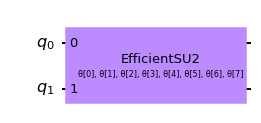

In [6]:
entangled_layer = []
for qbs in WC_paris :
    if qbs[0]<qbs[1] and qbs[1]<num_qubits :
        entangled_layer.append(qbs)

ansatz = init_state.compose( EfficientSU2(num_qubits,['ry','rz'], entanglement=entangled_layer, reps=1 ) )
ansatz.draw(output='mpl')

We define a callback function, to have the behavior of the algorithm by iterations.

In [7]:
def callback( evals, params, energy, extra  ):  
    display("{}, {}".format(evals,energy))
    clear_output(wait=True)
    parameters.append(params)
    evaluations.append(evals)

parameters  = []
evaluations = []
energies    = [] 

We select SPSA with 100 iterations as classical optimizer.

In [8]:
optimizer = SPSA( maxiter=100, last_avg=1 )

Initial parameters for the optimization

In [9]:
num_var = ansatz.num_parameters
pars = [0.01] * num_var

In [10]:
result_exact.eigenvalue 

(-2.4939592074349357+2.8162399132712285e-17j)

VQE with entangled grouping

In [11]:
solver = VQE( ansatz, optimizer, pars, grouping = 'Entangled' )
results = solver.compute_minimum_eigenvalue(qubit_op)
print( results.eigenvalue )

-2.40625


VQE with TPB grouping

In [12]:
solver = VQE( ansatz, optimizer, pars, grouping = 'TPB' )
results = solver.compute_minimum_eigenvalue(qubit_op)
print( results.eigenvalue )

-2.42578125


VQE with entangled grouping and the connectivity of ibmq_paris

In [13]:
solver = VQE( ansatz, optimizer, pars, grouping = 'Entangled', conectivity = WC_paris )
results = solver.compute_minimum_eigenvalue(qubit_op)
print( results.eigenvalue )

-2.32421875


Testing callback function

In [14]:
parameters  = []
evaluations = []
solver = VQE( ansatz, optimizer, pars, grouping = 'Entangled', callback=callback )
results = solver.compute_minimum_eigenvalue(qubit_op)
print( results.eigenvalue )

-2.439453125


Testing simulation with noise model

In [15]:
# parameters  = []
# evaluations = []
# optimizer   = SPSA( maxiter=100, last_avg=1 )
# solver = VQE( ansatz, optimizer, pars, grouping = 'Entangled', callback=callback, quantum_instance=backend_noise )
# results = solver.compute_minimum_eigenvalue(qubit_op)
# print( results.eigenvalue )

In [16]:
# plt.plot( evaluations )

Testing quantum instance

In [17]:
qi = QuantumInstance( backend_sim, shots = NUM_SHOTS )
parameters  = []
evaluations = []
optimizer   = SPSA( maxiter=100, last_avg=1 )
solver = VQE( ansatz, optimizer, pars, grouping = 'Entangled', quantum_instance=qi )
results = solver.compute_minimum_eigenvalue(qubit_op)
print( results.eigenvalue )

-2.0634765625


In [20]:
print(results)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 200,
    'eigenstate': {   '00': 0.036643873123620545,
                      '01': 0.6733269195754763,
                      '10': 0.6275339258757251,
                      '11': 0.38921620959628594},
    'eigenvalue': -2.0634765625,
    'optimal_parameters': {   ParameterVectorElement(θ[7]): 2.2465047855503624,
                              ParameterVectorElement(θ[2]): 0.01850545767266956,
                              ParameterVectorElement(θ[4]): -0.985759801729,
                              ParameterVectorElement(θ[5]): -1.6092356287472815,
                              ParameterVectorElement(θ[1]): -2.675173018821848,
                              ParameterVectorElement(θ[0]): -2.0683384508891804,
                              ParameterVectorElement(θ[3]): 1.4478356451607668,
                              ParameterVectorElement(θ[6]): 1.4379030382365012},
    'optimal_point': array([-2.06833845, -2.67517302,  0.018

In [21]:
solver._energy_evaluation

<bound method VQE._energy_evaluation of <VQE_v2.VQE object at 0x000001E929A50A00>>

Testing another function of the VQE class

In [22]:
solver._ansatz

In [23]:
solver.construct_expectation( pars, qubit_op )[0].draw()

┌────────────────────────────────────────────────────────┐     ┌───┐»
q69606_0: ┤0                                                       ├──■──┤ H ├»
          │  EfficientSU2(θ[0],θ[1],θ[2],θ[3],θ[4],θ[5],θ[6],θ[7]) │┌─┴─┐└┬─┬┘»
q69606_1: ┤1                                                       ├┤ X ├─┤M├─»
          └────────────────────────────────────────────────────────┘└───┘ └╥┘ »
   c16: 2/═════════════════════════════════════════════════════════════════╩══»
                                                                           1  »
«          ┌─┐
«q69606_0: ┤M├
«          └╥┘
«q69606_1: ─╫─
«           ║ 
«   c16: 2/═╩═
«           0

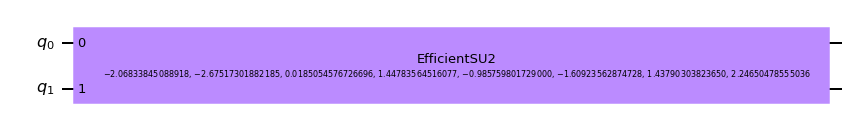

In [24]:
solver.get_optimal_circuit().draw(output='mpl')

In [25]:
solver.get_optimal_cost()

-2.0634765625

In [26]:
solver.get_optimal_vector()

{'01': 0.6785640859565145,
 '10': 0.618619777963411,
 '11': 0.3935825536815625,
 '00': 0.04419417382415922}

In [27]:
# solver.get_prob_vector_for_params()

In [28]:
# solver.get_probabilities_for_counts()

In [29]:
solver._initial_point

[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

In [30]:
solver.optimal_params

array([-2.06833845, -2.67517302,  0.01850546,  1.44783565, -0.9857598 ,
       -1.60923563,  1.43790304,  2.24650479])

In [31]:
solver._optimizer

In [37]:
solver._quantum_instance.compile_config

{'initial_layout': [0, 1], 'seed_transpiler': None, 'optimization_level': None}

In [33]:
solver.supports_aux_operators()

False

In [34]:
print( solver.print_settings() )


==================== Setting of VQE ============================
Algorithm: VQE
-- ansatz:      ┌────────────────────────────────────────────────────────┐
q_0: ┤0                                                       ├
     │  EfficientSU2(θ[0],θ[1],θ[2],θ[3],θ[4],θ[5],θ[6],θ[7]) │
q_1: ┤1                                                       ├
     └────────────────────────────────────────────────────────┘
-- optimizer: <qiskit.algorithms.optimizers.spsa.SPSA object at 0x000001E929A50C40>
-- initial_point: [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
-- order: [4, 3, 2, 1]
-- conectiviy: [(0, 1), (1, 0)]
-- grouping: Entangled
-- eval_count: 200
-- callback: None
-- total_time: 22.31440782546997
-- quantum_instance: 
Qiskit Terra version: 0.18.3
Backend: 'aer_simulator (AerProvider)', with following setting:
{'basis_gates': ['ccx', 'cp', 'cswap', 'csx', 'cu', 'cu1', 'cu2', 'cu3', 'cx', 'cy', 'cz', 'delay', 'diagonal', 'h', 'id', 'initialize', 'mcp', 'mcphase', 'mcr', 'mcrx', 'mcr

In [35]:
import qiskit.tools.jupyter
%qiskit_version_table

C:\Users\lucia\miniconda3\lib\site-packages\qiskit\aqua\__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')
